#Hydrologic soil group evaluation


Hydrologic soil group are based on estimates of run off potential. Soils are assigned to one of four groups according to the rate of water infiltration when the soil are not protected by vegetation, are thoroughly wet and receive precipitation from long-duration storms. 
Accordingly with the USDA the group are defined as follow:
•	Group A. Soils having a high infiltration rate (low runoff potential) when thoroughly wet. These consist mainly of deep, well drained to excessively drained sands or gravelly sands. These soils have a high rate of water transmission. 
•	Group B. Soils having a moderate infiltration rate when thoroughly wet. These consist chiefly of moderately deep or deep, moderately well drained, or well drained soils that have moderately fine texture to moderately coarse texture. These soils have a moderate rate of water transmission. 
•	Group C. Soils having a slow infiltration rate when thoroughly wet. These consist chiefly of soils having a layer that impedes the downward movement of water or soils of moderately fine texture or fine texture. These soils have a slow rate of water transmission. 
•	Group D. Soils having a very slow infiltration rate (high runoff potential) when thoroughly wet. These consist chiefly of clays that have a high shrink-swell potential, soils that have a high-water table, soils that have a claypan or clay layer at or near the surface, and soils that are shallow over nearly impervious material. These soils have a very slow rate of water transmission.



<table>
<title></title>
<thead>
<tr>
<th>hydologic soil grup</th>
<th>Criteria</th>
</tr>
</thead>
<tbody>
<tr>
<td>A</td>
<td>Saturated hydraulic conductivity is high and internal water occurence is deep</td>
</tr>

<tr>
<td>B</td>
<td>Saturated hydraulic conductivity moderately high and internal water occurence is deep</td>
</tr>

<tr>
<td>C</td>
<td>Saturated hydraulic conductivity is moderately low and internal free water occurence is deeper than shallow</td>
</tr>

<tr>
<td>D</td>
<td>Saturated hydraulic conductivity is low and/or internal free water occurence is shallow</td>
</tr>

</tbody>
</table>


the criteria are based on the assumption that the minimu, satrurater hydraulic conductivity occurs with in the uppermost 0.5 m. if the minumum occurs between 0.5 - 1 m, then the saturated hydraulic conductivity for the purpuse of placement is increased one class.
If the minimum occurs below 1m, then the value for the soil ios based on values aboce 1 m using the rules as previosly given.

For a more detailed description, please refer to the Soil Survey Manual contained in the USDA Handbook.

**Required input files:** *Group_Ksat.tif, Group_Ksat_Rosetta.tif (obtainable with Ksat_Brakeinsiel_Rosetta.ipynb), Min60_100_B.tif, Min60_100_B.tif (obtainable with minKsat_position.ipynb), Shallow_watertable_area (computed with QGIS).*

#Library installation
The library installed is rasterio. This library allowed to elaborate save and load the raster files.

In [1]:
pip install rasterio

     |████████████████████████████████| 19.3MB 33.8MB/s 


#input data selection and loading

In the following section the input data required to evaluate the hydrological soil group are loaded.
The program allows to choose the input generated with Rawls and Brakensiek method or with Rosetta 3a (once selected the method press enter to continue).
The unput required are:
•	The saturated hydraulic conductivity (Ksat)map that can be generated using the program Ksat_Brakeinsiel_Rosetta.ipynb
•	A map that indicates the zones where the Ksat min value is collocated between 60 and 100 cm (this map can be generated with the code (minKsat_position.ipynb).
•	A map that indicates the shallow water level area. This map was evaluated externally using QGIS. The information related to the water table level are provided by the European Soil Data Centre (ESDAC). The data are available in the Dataset Soil Project specifically in the section of [Groundwater Resource maps of Europe](https://esdac.jrc.ec.europa.eu/content/groundwater-resources-maps-europe-0). This data has been combined with the [European Digital elevation model](https://land.copernicus.eu/imagery-in-situ/eu-dem/eu-dem-v1.1?tab=metadata) (30 m resolution) provided by the Copernicus Land Monitoring service to estimate the water table depth.
It was not possible to develop a code that automatically evaluate the depth of the water table because the water table level data are not open.




In [70]:
w = input("slect the method used to evaluate GroupKsat, digit 1 for Rawls and Brakensiek, 1983 or 2 for Rosetta 3a:  ")
if int(w) != 1 and int(w) != 2:
  raise Exception('input not valid! please run again the section and provide a valid input to continue')

slect the method used to evaluate GroupKsat, digit 1 for Rawls and Brakensiek, 1983 or 2 for Rosetta 3a:  2


In [71]:
import numpy as np
import rasterio
if int(w)==1:
  Gksat = rasterio.open("Group_ksat.tif", driver="GTiff")
  min60_100 = rasterio.open("Min60_100_B.tif", driver="GTiff")
  print('Ksat Groups evaluated with rawls and Brakensiek Loaded')
else:
  Gksat = rasterio.open("Group_ksat_Rosetta.tif", driver="GTiff")
  min60_100 = rasterio.open("Min60_100_R.tif", driver="GTiff")
  print('Ksat Groups evaluated with Rosetta Loaded')

Ksat Groups evaluated with Rosetta Loaded


In [72]:
Shalow_watertable_area = rasterio.open("Shalow_watertable_area.tif", driver="GTiff")

#computation

Following the instruction written in the notebook introduction the hydrologic soil group is evaluated.

In [15]:
# combining the Ksat info with the Shallow water areas.

GK = Gksat.read(1)
SW = Shalow_watertable_area.read(1)
M60100 = min60_100.read(1)
GI = ((GK==4)+(GK==-1)+(GK==1))*GK +(GK==2)*(SW==1)*1 +(GK==3)*(SW==1)*2 + (GK==2)*(SW==0)*2 +(GK==3)*(SW==0)*3
GI = (GI<4)*M60100+GI

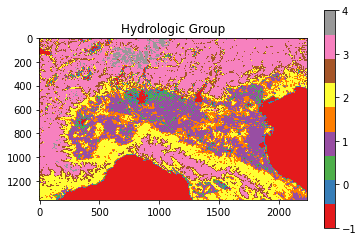

In [16]:
import matplotlib.pyplot as plt

plt.imshow(GI, cmap='Set1')
plt.colorbar()
plt.title('Hydrologic Group')
plt.show()

In [17]:
# save Ksat group
Hydrologic_Group = Shalow_watertable_area.meta
Hydrologic_Group.update(
    dtype=rasterio.float32,
    count = 1)

# Create the file
with rasterio.open('Hydrologic_Group.tif', 'w', **Hydrologic_Group) as dst:
        dst.write_band(1, GI.astype(rasterio.float32))